In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torchsummary import summary

In [2]:
trainset = torch.load('./dataset/train.pt')
valset = torch.load('./dataset/val.pt')

datasets = {'train': trainset, 'val': valset}

batch_size=4

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(datasets['val'], batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(datasets[x]) for x in datasets.keys()
}

dataset_sizes

{'train': 1159, 'val': 290}

torch.Size([4, 1, 480, 640]) torch.Size([4, 3, 480, 640])
0.0 10.0 1.7463216 1.8041029
0.0 1.0 0.12646131 0.33236852


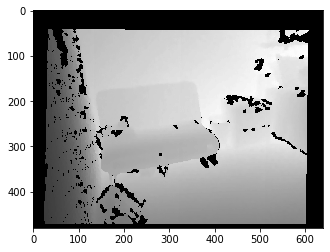

In [3]:
inputs, masks = next(iter(dataloaders['train']))
inputs = inputs.unsqueeze(1)
print(inputs.size(), masks.size())
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(inputs[3][0], cmap=plt.cm.gist_gray)

In [4]:
# import Unet_bin

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# model = Unet_bin.UNet(3)
# model = model.to(device)

# summary(model, input_size=(1, 480, 640))

In [5]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss
import Unet_bin

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.unsqueeze(1)
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 3

model = Unet_bin.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001
/home/pdh/anaconda3/envs/plane/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/pdh/anaconda3/envs/plane/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
train: bce: 0.332791, dice: 0.873859, loss: 0.603325
val: bce: 0.288367, dice: 0.856223, loss: 0.572295
saving best model
3m 31s
Epoch 1/39
----------
LR 0.0001
